In [2]:
# Bootstrap paths for this notebook 

from pathlib import Path

def _bootstrap_paths():
    cwd = Path.cwd()
    project_root = cwd.parent if cwd.name == "Notebook" else cwd
    data_dir = project_root / "data"
    processed_dir = data_dir / "processed"
    index_dir = project_root / "index"
    index_dir.mkdir(parents=True, exist_ok=True)
    return project_root, processed_dir, index_dir

# If paths are already defined, keep them; otherwise define them.
try:
    PROJECT_ROOT
    PROCESSED_DIR
    INDEX_DIR
except NameError:
    PROJECT_ROOT, PROCESSED_DIR, INDEX_DIR = _bootstrap_paths()

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DIR:", PROCESSED_DIR, "exists:", PROCESSED_DIR.exists())
print("INDEX_DIR:", INDEX_DIR, "exists:", INDEX_DIR.exists())

PROJECT_ROOT: /Users/rellu/Documents/PTAB_Project/AI-Builders-Bootcamp-5/PTAB_Project3
PROCESSED_DIR: /Users/rellu/Documents/PTAB_Project/AI-Builders-Bootcamp-5/PTAB_Project3/data/processed exists: True
INDEX_DIR: /Users/rellu/Documents/PTAB_Project/AI-Builders-Bootcamp-5/PTAB_Project3/index exists: True


In [3]:
# Count and list processed documents

from pathlib import Path

# figure out project root (works if run from /Notebook or elsewhere)
cwd = Path.cwd()
PROJECT_ROOT = cwd.parent if cwd.name == "Notebook" else cwd
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

# find all processed .txt files
files = sorted(PROCESSED_DIR.glob("*.txt"))

print(f"✅ Found {len(files)} processed documents in {PROCESSED_DIR}")

# show first few names so you can sanity-check
for f in files[:5]:
    print(" -", f.name)
if len(files) > 5:
    print(" ...")

✅ Found 27 processed documents in /Users/rellu/Documents/PTAB_Project/AI-Builders-Bootcamp-5/PTAB_Project3/data/processed
 - 2024000857_2025-08-26_75d26863-bf26-41d9-92c5-17605cea3c51.txt
 - 2024001050_2025-08-26_96b1de0c-7637-4aeb-b290-ea76af8a4087.txt
 - 2024001413_2025-08-25_3c30a4ca-c489-4853-87d7-2b698c11348b.txt
 - 2024002039_2025-08-25_8cf23631-8e2c-4060-a7c4-534b97087a2d.txt
 - 2024002880_2025-08-26_6583dc03-0b34-46bd-a958-93345eb5e15c.txt
 ...


In [4]:
# Load processed fles and chuck text

from typing import List, Dict
import math

def load_processed_docs(processed_dir=PROCESSED_DIR) -> List[Dict]:
    """
    Load processed .txt files where:
      - line 1 = title
      - rest = body
    Returns a list of dicts: {doc_id, title, body}
    """
    docs = []
    for p in sorted(processed_dir.glob("*.txt")):
        raw = p.read_text(encoding="utf-8", errors="ignore")
        lines = raw.splitlines()
        title = (lines[0].strip() if lines else p.stem) or p.stem
        body = "\n".join(lines[1:]).strip()
        docs.append({"doc_id": p.stem, "title": title, "body": body})
    return docs

def chunk_text(
    text: str,
    max_chars: int = 2000,
    overlap: int = 200
) -> List[str]:
    """
    Split long text into overlapping chunks by character count.
    - max_chars: target size of each chunk
    - overlap:  number of characters shared between consecutive chunks
    Rationale: simple, no extra deps; good enough for an MVP.
    """
    if not text:
        return []
    # Normalize whitespace a bit
    t = " ".join(text.split())
    chunks = []
    start = 0
    n = len(t)
    while start < n:
        end = min(start + max_chars, n)
        chunk = t[start:end]
        chunks.append(chunk)
        if end == n:
            break
        # move start forward with overlap
        start = end - overlap
        if start < 0:
            start = 0
    return chunks

# ---- run: build chunk records ----
docs = load_processed_docs(PROCESSED_DIR)

chunk_records: List[Dict] = []
for d in docs:
    pieces = chunk_text(d["body"], max_chars=2000, overlap=200)
    for i, piece in enumerate(pieces):
        chunk_records.append({
            "doc_id": d["doc_id"],
            "chunk_id": i,
            "title": d["title"],
            "text": piece
        })

print(f"✅ Loaded {len(docs)} documents.")
print(f"✅ Created {len(chunk_records)} chunks "
      f"(avg ~{(len(chunk_records)/len(docs)) if docs else 0:.1f} chunks/doc)")

# Peek at one
if chunk_records:
    s = chunk_records[0]
    print("Example chunk:", f"{s['doc_id']}#chunk{s['chunk_id']}")
    print("Title:", s["title"])
    print("Text preview:", s["text"][:200], "…")

✅ Loaded 27 documents.
✅ Created 261 chunks (avg ~9.7 chunks/doc)
Example chunk: 2024000857_2025-08-26_75d26863-bf26-41d9-92c5-17605cea3c51#chunk0
Title: 2024000857 2025 08 26 75d26863 bf26 41d9 92c5 17605cea3c51
Text preview: U NITED STATES PATENT AND TRADEMARK O FFICE UNITED STATES DEPARTMENT OF COMMERCE United States Patent and Trademark Office Address: COMMISSIONER FOR PATENTS P.O. Box 1450 Alexandria, Virginia 22313-14 …


In [5]:
# Load a sentence-transformer model for embeddings

from sentence_transformers import SentenceTransformer

# picked a small, fast model good enough for semantic search that was demoed in class
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

print(f"Loading embedding model: {MODEL_NAME} ...")
model = SentenceTransformer(MODEL_NAME)

# quick test: embed a dummy sentence
test_vec = model.encode("This is a PTAB decision about semiconductors.")
print("Vector shape:", test_vec.shape)
print("First 5 numbers:", test_vec[:5])

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2 ...
Vector shape: (384,)
First 5 numbers: [-0.04103503  0.02362933 -0.03668882 -0.03065008 -0.04489972]


In [6]:
# Embed chunk_records and save index files

import numpy as np
import json

texts = [rec["text"] for rec in chunk_records]

print(f"Encoding {len(texts)} chunks... this may take a minute.")

embeddings = model.encode(
    texts,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("Embeddings shape:", embeddings.shape)  # e.g., (N_chunks, 384)

# Save embeddings array
np.save(INDEX_DIR / "embeddings.npy", embeddings)

# Save metadata
meta_path = INDEX_DIR / "meta.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(chunk_records, f, ensure_ascii=False, indent=2)

print(f"✅ Saved embeddings to {INDEX_DIR/'embeddings.npy'}")
print(f"✅ Saved metadata to {meta_path}")

Encoding 261 chunks... this may take a minute.
Embeddings shape: (261, 384)
✅ Saved embeddings to /Users/rellu/Documents/PTAB_Project/AI-Builders-Bootcamp-5/PTAB_Project3/index/embeddings.npy
✅ Saved metadata to /Users/rellu/Documents/PTAB_Project/AI-Builders-Bootcamp-5/PTAB_Project3/index/meta.json


Embeddings shape: (261, 384)
Explained variance (PC1, PC2): [0.09849797 0.07370897]


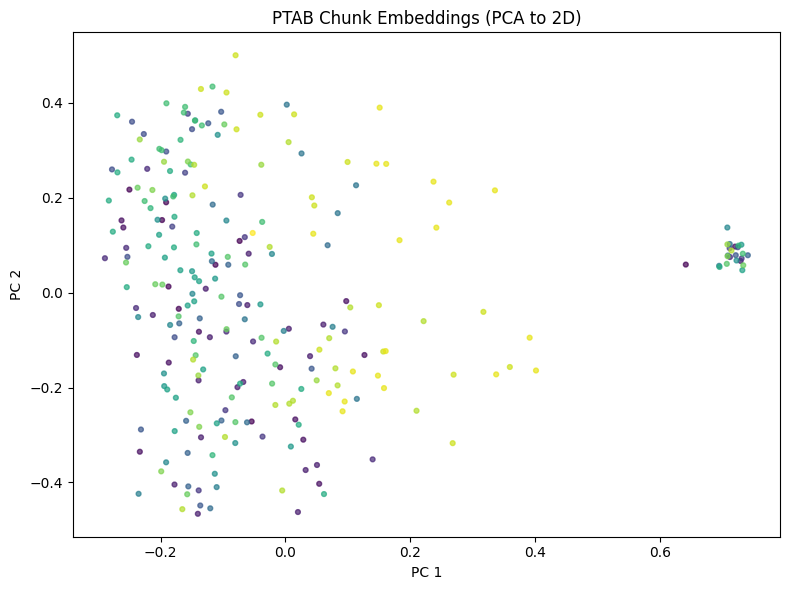

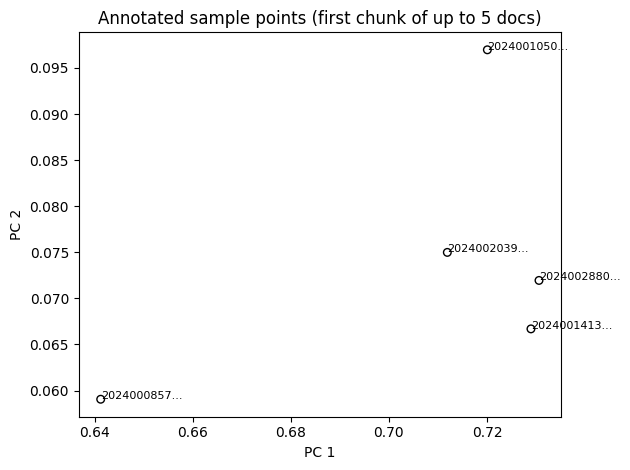

In [7]:
# Visualize chunk embeddings with PCA (2D)

from pathlib import Path
import json
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

# --- make sure paths exist (must run from /Notebook or project root) ---
cwd = Path.cwd()
PROJECT_ROOT = cwd.parent if cwd.name == "Notebook" else cwd
INDEX_DIR = PROJECT_ROOT / "index"

# --- load embeddings + metadata if not already in memory ---
try:
    embeddings  # check if exists in this kernel
    chunk_records
except NameError:
    print("Loading embeddings and metadata from disk...")
    embeddings = np.load(INDEX_DIR / "embeddings.npy")
    with open(INDEX_DIR / "meta.json", "r", encoding="utf-8") as f:
        chunk_records = json.load(f)

print("Embeddings shape:", embeddings.shape)  # (N_chunks, 384) for MiniLM

# --- PCA: reduce to 2D for plotting ---
pca = PCA(n_components=2, random_state=0)
emb_2d = pca.fit_transform(embeddings)
print("Explained variance (PC1, PC2):", pca.explained_variance_ratio_)

# --- assign a small integer color/group per doc_id ---
doc_to_idx = {}
colors = []
labels = []
for rec in chunk_records:
    did = rec["doc_id"]
    if did not in doc_to_idx:
        doc_to_idx[did] = len(doc_to_idx)
    colors.append(doc_to_idx[did])
    labels.append(did)

colors = np.array(colors)

# --- make a simple scatter plot ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, s=12, alpha=0.7)
plt.title("PTAB Chunk Embeddings (PCA to 2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

# --- (optional) annotate a few points per document for intuition ---
#   To avoid clutter, we annotate at most the first chunk of up to 5 documents.
annotated = set()
count = 0
for i, rec in enumerate(chunk_records):
    did = rec["doc_id"]
    if did not in annotated:
        plt.scatter(emb_2d[i, 0], emb_2d[i, 1], s=30, edgecolors='black', facecolors='none')
        plt.text(emb_2d[i, 0], emb_2d[i, 1], did[:10] + "...", fontsize=8)
        annotated.add(did)
        count += 1
        if count >= 5:
            break
plt.title("Annotated sample points (first chunk of up to 5 docs)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

In [17]:
# Hard coded semantic search for fun!

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import CrossEncoder
import numpy as np


# Load embeddings + metadata if not in memory
try:
    embeddings
    chunk_records
except NameError:
    embeddings = np.load(INDEX_DIR / "embeddings.npy")
    import json
    with open(INDEX_DIR / "meta.json", "r", encoding="utf-8") as f:
        chunk_records = json.load(f)


# ensure embeddings + chunk_records + model are in memory (or load from disk)
try:
    embeddings
    chunk_records
    model
except NameError:
    # load from disk if needed
    import json
    embeddings = np.load(INDEX_DIR / "embeddings.npy")
    with open(INDEX_DIR / "meta.json", "r", encoding="utf-8") as f:
        chunk_records = json.load(f)
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# hardcode query
query = "claims cancelled in the final written decision"
print("Query:", query)

# embed query and fetch top-N by cosine similarity
q_emb = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
sims = cosine_similarity(q_emb, embeddings)[0]
N = 50  # pool size for re-ranking
topN_idx = np.argsort(-sims)[:N]

# build pairs (query, candidate_text) for cross-encoder
pairs = [[query, chunk_records[i]["text"]] for i in topN_idx]

# load a lightweight cross-encoder and score the pairs
#    This model scores how well a passage answers/matches the query.
print("Loading cross-encoder for reranking...")
ce = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")  # small & fast
ce_scores = ce.predict(pairs)  # higher = better match

# re-order topN by cross-encoder score, then print top-k
k = 5
reranked = sorted(zip(topN_idx, ce_scores), key=lambda x: -x[1])[:k]

print(f"\nTop {k} after re-ranking:")
for rank, (i, score) in enumerate(reranked, start=1):
    rec = chunk_records[i]
    print(f"{rank}. CE_score={score:.3f} | cosine={sims[i]:.3f} | doc={rec['doc_id']} | chunk={rec['chunk_id']}")
    print("   Title:", rec["title"][:120])
    print("   Snippet:", rec["text"][:220].replace("\n", " "), "...")
    print()

Query: claims cancelled in the final written decision
Loading cross-encoder for reranking...

Top 5 after re-ranking:
1. CE_score=0.948 | cosine=0.427 | doc=2024004106_2025-08-27_32f45f1a-66d2-4e87-82dc-67fa1196f3a5 | chunk=11
   Title: 2024004106 2025 08 27 32f45f1a 66d2 4e87 82dc 67fa1196f3a5
   Snippet: drawings for failing to show this limitation was granted. The petition found the limitation is illustrated in Figure 3 and described on pages 4–5 of the Specification. Decision Granting Petition on April 3, 2024, Control ...

2. CE_score=-0.806 | cosine=0.417 | doc=IPR2024-00736_2025-08-25_171166608 | chunk=0
   Title: IPR2024 00736 2025 08 25 171166608
   Snippet: Trials@uspto.gov Paper 40 Tel: 571-272-7822 Date: August 25, 2025 UNITED STATES PATENT AND TRADEMARK OFFICE BEFORE THE PATENT TRIAL AND APPEAL BOARD DISNEY MEDIA & ENTERTAINMENT DISTRIBUTION LLC, Petitioner, v. DIGITAL M ...

3. CE_score=-0.807 | cosine=0.550 | doc=2025000819_2025-08-25_7294b159-c4dc-4aa0-a8d9-b9e6eb178bc4

In [26]:
# Reusable semantic search (with optional cross-encoder rerank) so previous cell don't have to be rerun

from typing import List, Dict, Any
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def semantic_search(
    query: str,
    k: int = 5,
    pool_size: int = 50,
    use_rerank: bool = True
) -> List[Dict[str, Any]]:
    """
    Run a semantic search over chunk embeddings.
    - query: natural language query
    - k: number of results to return
    - pool_size: how many cosine hits to consider before optional rerank
    - use_rerank: if True, rerank top pool_size with a cross-encoder
    
    Returns a list of dicts:
      { "rank": int, "doc_id": str, "chunk_id": int,
        "title": str, "score": float, "score_type": "ce"|"cosine",
        "text": str, "global_idx": int }
    """
    # redundancy to ensure we have embedding tools
    try:
        _ = model
    except NameError:
        from sentence_transformers import SentenceTransformer
        MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
        print(f"Loading embedding model: {MODEL_NAME}")
        globals()["model"] = SentenceTransformer(MODEL_NAME)

    try:
        _ = embeddings
        _ = chunk_records
    except NameError:
        import json
        idx_dir = INDEX_DIR
        if "INDEX_DIR" not in globals():
            from pathlib import Path
            cwd = Path.cwd()
            proj = cwd.parent if cwd.name == "Notebook" else cwd
            idx_dir = proj / "index"
        globals()["embeddings"] = np.load(idx_dir / "embeddings.npy")
        with open(idx_dir / "meta.json", "r", encoding="utf-8") as f:
            globals()["chunk_records"] = json.load(f)

    # embed query and compute cosine similarities
    q_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    sims = cosine_similarity(q_vec, embeddings)[0]
    topN = np.argsort(-sims)[:max(k, pool_size)]

    if not use_rerank:
        results = []
        for rank, i in enumerate(topN[:k], start=1):
            rec = chunk_records[i]
            results.append({
                "rank": rank,
                "doc_id": rec["doc_id"],
                "chunk_id": rec["chunk_id"],
                "title": rec["title"],
                "score": float(sims[i]),
                "score_type": "cosine",
                "text": rec["text"],
                "global_idx": int(i),
            })
        return results

    # optional: rerank with a small cross-encoder
    from sentence_transformers import CrossEncoder
    pairs = [[query, chunk_records[i]["text"]] for i in topN]
    ce = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
    ce_scores = ce.predict(pairs)

    # sort by ce score desc
    ranked = sorted(zip(topN, ce_scores), key=lambda x: -x[1])[:k]

    results = []
    for rank, (i, ce_score) in enumerate(ranked, start=1):
        rec = chunk_records[i]
        results.append({
            "rank": rank,
            "doc_id": rec["doc_id"],
            "chunk_id": rec["chunk_id"],
            "title": rec["title"],
            "score": float(ce_score),
            "score_type": "ce",
            "text": rec["text"],
            "global_idx": int(i),
        })
    return results

# --- quick demo usage (you can change the query) ---
demo_query = "decisions where claims were cancelled in the final written decision"
hits = semantic_search(demo_query, k=5, pool_size=50, use_rerank=True)
for h in hits:
    print(f"{h['rank']}. [{h['score_type']}={h['score']:.3f}] doc={h['doc_id']} chunk={h['chunk_id']}")
    print("   Title :", h['title'][:120])
    print("   Snip  :", h['text'][:220].replace('\n',' '), "...\n")

1. [ce=-1.351] doc=2024004106_2025-08-27_32f45f1a-66d2-4e87-82dc-67fa1196f3a5 chunk=11
   Title : 2024004106 2025 08 27 32f45f1a 66d2 4e87 82dc 67fa1196f3a5
   Snip  : drawings for failing to show this limitation was granted. The petition found the limitation is illustrated in Figure 3 and described on pages 4–5 of the Specification. Decision Granting Petition on April 3, 2024, Control ...

2. [ce=-1.927] doc=IPR2024-00736_2025-08-25_171166608 chunk=0
   Title : IPR2024 00736 2025 08 25 171166608
   Snip  : Trials@uspto.gov Paper 40 Tel: 571-272-7822 Date: August 25, 2025 UNITED STATES PATENT AND TRADEMARK OFFICE BEFORE THE PATENT TRIAL AND APPEAL BOARD DISNEY MEDIA & ENTERTAINMENT DISTRIBUTION LLC, Petitioner, v. DIGITAL M ...

3. [ce=-2.052] doc=2025000819_2025-08-25_7294b159-c4dc-4aa0-a8d9-b9e6eb178bc4 chunk=7
   Title : 2025000819 2025 08 25 7294b159 c4dc 4aa0 a8d9 b9e6eb178bc4
   Snip  :  Further, Appellant relies on the same arguments presented for claim 1 as the basis for seekin